In [ ]:
!pip install --upgrade gensim scipy



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 52.2 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from gensim.models import Word2Vec
import joblib
import warnings
warnings.filterwarnings('ignore')

# Helper function to clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


ModuleNotFoundError: No module named 'gensim'

In [ ]:
# Load the dataset
DATA_PATH = '/content/it_domain_questions.csv'  # Adjust path if needed
df = pd.read_csv(DATA_PATH, encoding='utf-8')
print('Dataset shape:', df.shape)
df.head(10)


Dataset shape: (1200, 2)


,question,domain
0,Explain the purpose of feature scaling in mach...,Data Science
1,What is the difference between supervised and ...,Data Science
2,How is overfitting detected in a model? (examp...,Data Science
3,Explain the purpose of feature scaling in mach...,Data Science
4,What are the common evaluation metrics for cla...,Data Science
5,What is the difference between supervised and ...,Data Science
6,How is overfitting detected in a model? (examp...,Data Science
7,How is overfitting detected in a model? (examp...,Data Science
8,What are decision trees and how do they work? ...,Data Science
9,How is overfitting detected in a model? (examp...,Data Science


## Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand its structure, distribution, and key characteristics. This includes:
 - Domain distribution
 - Word and character counts
 - Top words overall
 - Word clouds for each domain
 - Visualizations for better insights


,question,domain,clean_q,word_count,char_count
1184,"Explain the difference between IaaS, PaaS, and...",Cloud Computing,explain the difference between iaas paas and s...,10,61
368,What is the difference between symmetric and a...,Cybersecurity,what is the difference between symmetric and a...,11,78
280,What are common types of malware? (example 40),Cybersecurity,what are common types of malware example 40,8,43
1060,How does AWS Lambda work? (example 100),Cloud Computing,how does aws lambda work example 100,7,36
923,How does Docker improve software deployment? (...,DevOps,how does docker improve software deployment ex...,8,55
998,"Explain the difference between IaaS, PaaS, and...",Cloud Computing,explain the difference between iaas paas and s...,10,60
400,How does HTTPS secure communication? (example ...,Cybersecurity,how does https secure communication example 160,7,47
739,Explain the concept of Infrastructure as Code....,DevOps,explain the concept of infrastructure as code ...,9,56


Domain counts:
domain
Data Science       240
Cybersecurity      240
Web Development    240
DevOps             240
Cloud Computing    240
Name: count, dtype: int64

Word count statistics:
count    1200.000000
mean        8.886667
std         1.616374
min         5.000000
25%         8.000000
50%         9.000000
75%        10.000000
max        11.000000
Name: word_count, dtype: float64

Top 25 words overall:


,word,count
0,example,1200
1,what,663
2,is,598
3,the,537
4,how,401
5,and,334
6,of,294
7,explain,217
8,does,197
9,in,185


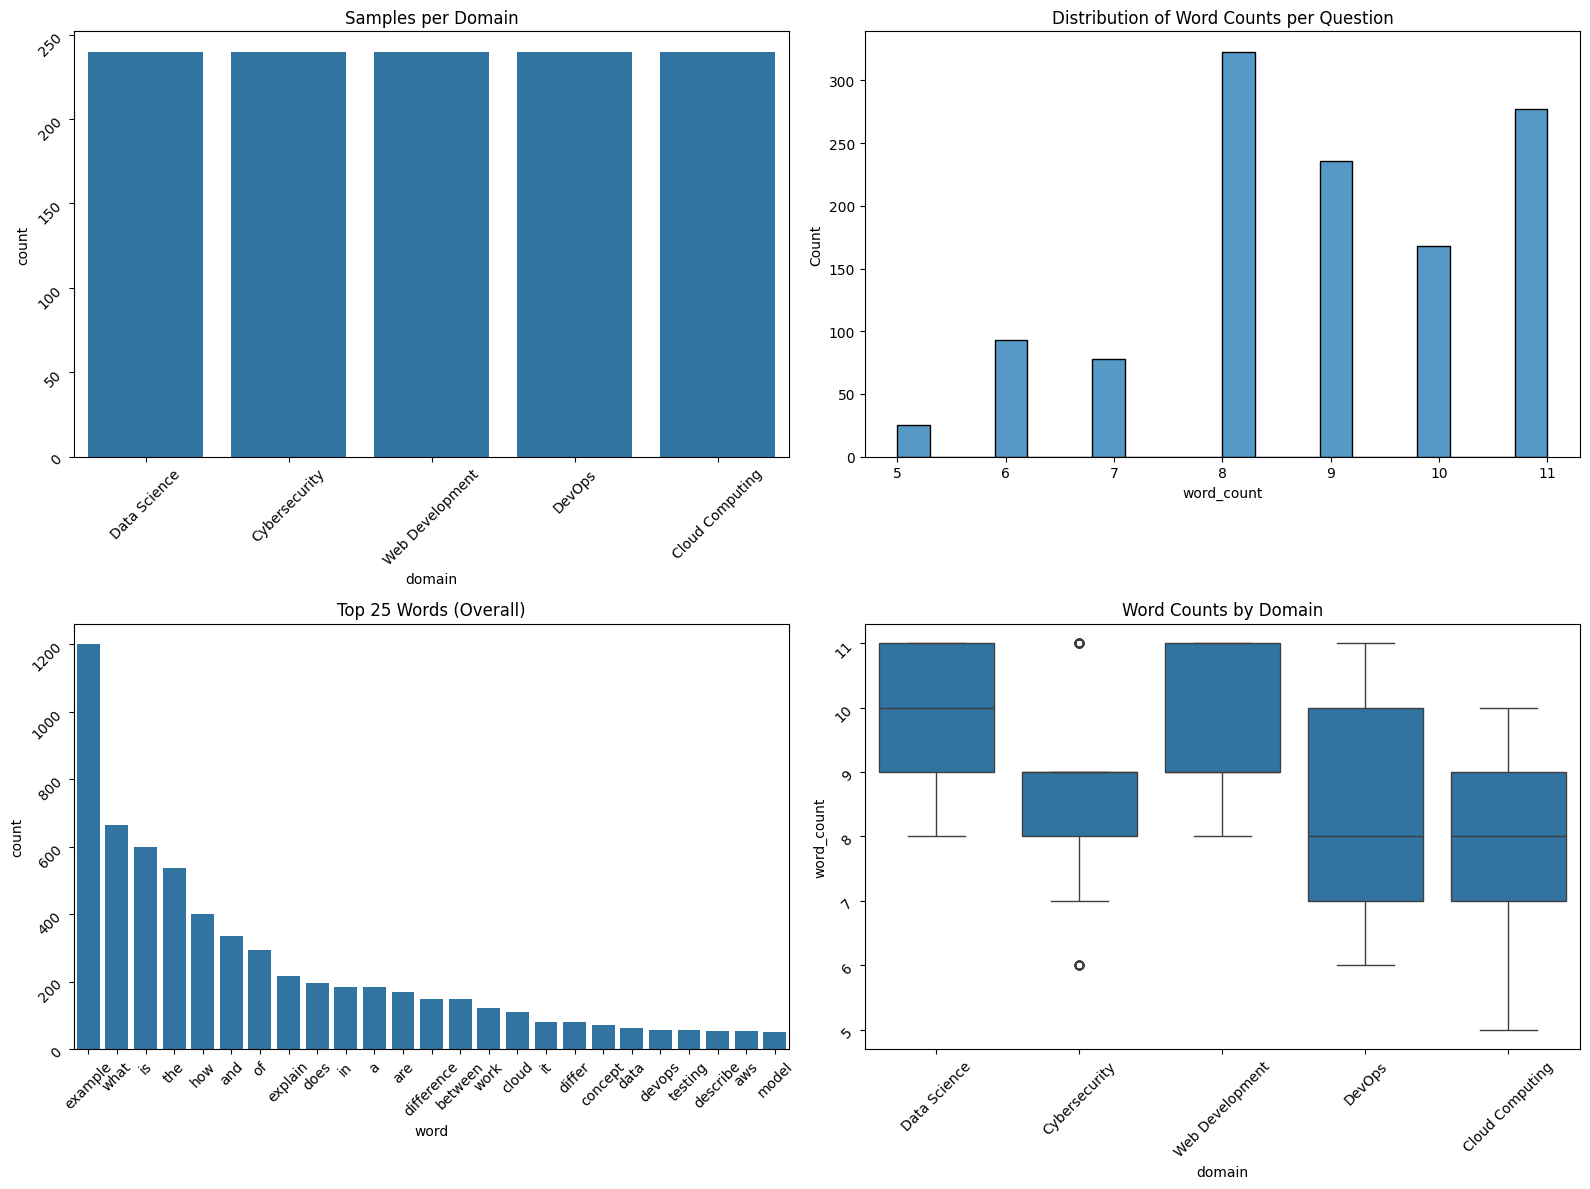

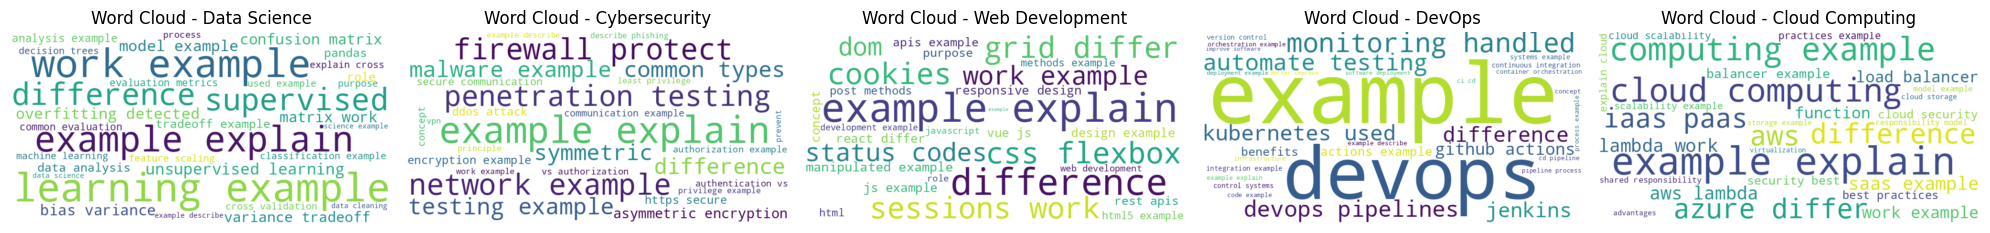

In [ ]:
# Preprocess text
df['question'] = df['question'].astype(str)
df['clean_q'] = df['question'].apply(clean_text)
df['word_count'] = df['clean_q'].apply(lambda x: len(x.split()))
df['char_count'] = df['clean_q'].apply(len)

# Display sample
display(df.sample(8))

# Domain counts
print('Domain counts:')
print(df['domain'].value_counts())

# Word count stats
print('\nWord count statistics:')
print(df['word_count'].describe())

# Top words overall
all_words = ' '.join(df['clean_q']).split()
top_words = Counter(all_words).most_common(25)
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])
print('\nTop 25 words overall:')
display(top_words_df)

# Plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Domain distribution
sns.countplot(data=df, x='domain', ax=axes[0, 0])
axes[0, 0].set_title('Samples per Domain')
axes[0, 0].tick_params(rotation=45)

# Word count distribution
sns.histplot(df['word_count'], bins=20, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Word Counts per Question')

# Top words barplot
sns.barplot(data=top_words_df, x='word', y='count', ax=axes[1, 0])
axes[1, 0].set_title('Top 25 Words (Overall)')
axes[1, 0].tick_params(rotation=45)

# Boxplot of word counts by domain
sns.boxplot(data=df, x='domain', y='word_count', ax=axes[1, 1])
axes[1, 1].set_title('Word Counts by Domain')
axes[1, 1].tick_params(rotation=45)

plt.tight_layout()
plt.show()

# Word clouds per domain
unique_domains = df['domain'].unique()
fig, axes = plt.subplots(1, len(unique_domains), figsize=(20, 5))
for i, domain in enumerate(unique_domains):
    text = ' '.join(df[df['domain'] == domain]['clean_q'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud - {domain}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## Feature Engineering: Word2Vec Embeddings

We train a Word2Vec model to generate vector embeddings for each question. Sentence embeddings are obtained by averaging word vectors. If Word2Vec fails, fallback to TF-IDF (but we assume gensim is available for this professional version).


In [ ]:
# Prepare tokenized sentences
sentences = [q.split() for q in df['clean_q']]

# Train Word2Vec
embedding_dim = 100
w2v_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4, epochs=20, seed=42)
print('Trained Word2Vec. Vocabulary size:', len(w2v_model.wv))

# Function to get sentence vector
def sentence_vector_w2v(tokens, model, dim):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

# Build embeddings matrix
X = np.vstack([sentence_vector_w2v(s, w2v_model, embedding_dim) for s in sentences])
print('Embeddings shape:', X.shape)


Trained Word2Vec. Vocabulary size: 396
Embeddings shape: (1200, 100)


## Model Training: K-Nearest Neighbors with Hyperparameter Tuning

We encode the labels, split the data, and train a KNN classifier with hyperparameter tuning using GridSearchCV to find the optimal parameters.


In [ ]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['domain'])
print('Encoded classes:', list(le.classes_))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train set shape:', X_train.shape, 'Test set shape:', X_test.shape)

# KNN with hyperparameter tuning
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_knn = grid_search.best_estimator_
print('Best hyperparameters:', grid_search.best_params_)

# Predictions
y_pred = best_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('KNN Accuracy:', acc)
print(classification_report(y_test, y_pred, target_names=le.classes_))


Encoded classes: ['Cloud Computing', 'Cybersecurity', 'Data Science', 'DevOps', 'Web Development']
Train set shape: (960, 100) Test set shape: (240, 100)
Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
KNN Accuracy: 1.0
                 precision    recall  f1-score   support

Cloud Computing       1.00      1.00      1.00        48
  Cybersecurity       1.00      1.00      1.00        48
   Data Science       1.00      1.00      1.00        48
         DevOps       1.00      1.00      1.00        48
Web Development       1.00      1.00      1.00        48

       accuracy                           1.00       240
      macro avg       1.00      1.00      1.00       240
   weighted avg       1.00      1.00      1.00       240



## Model Evaluation

Evaluate the model using confusion matrix, PCA, and t-SNE visualizations for embedding clusters.


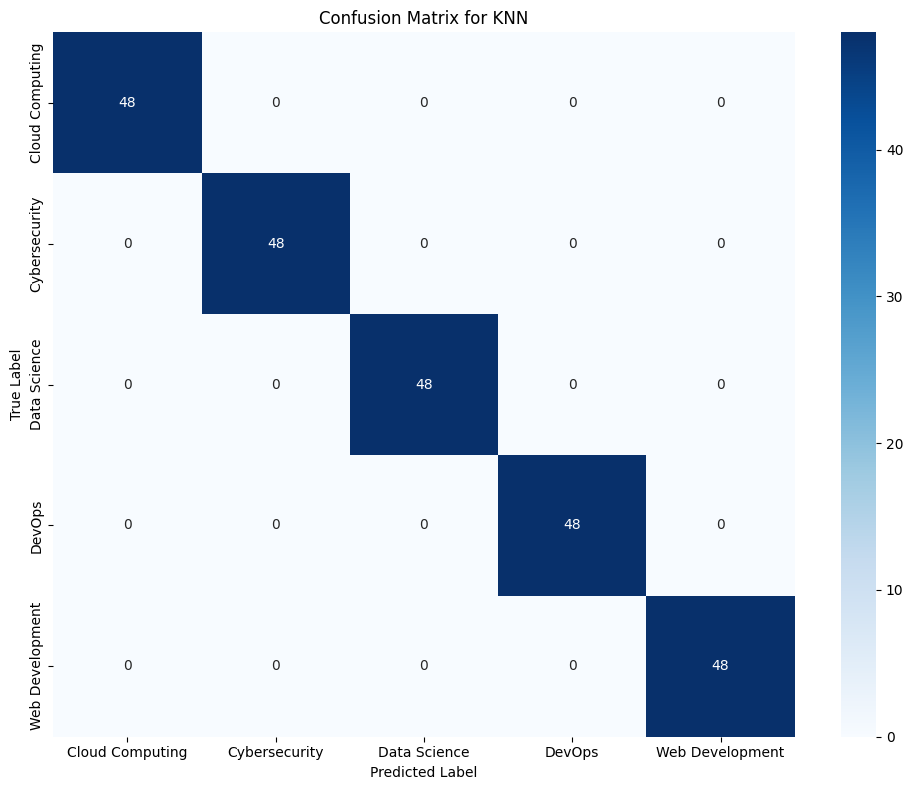

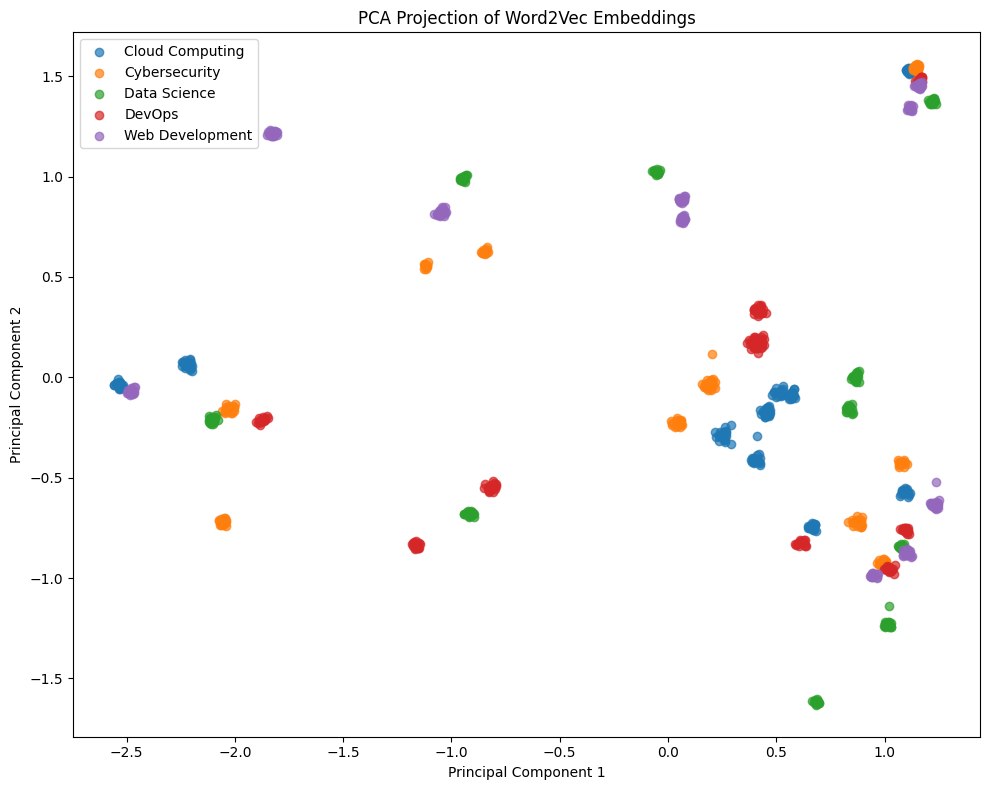

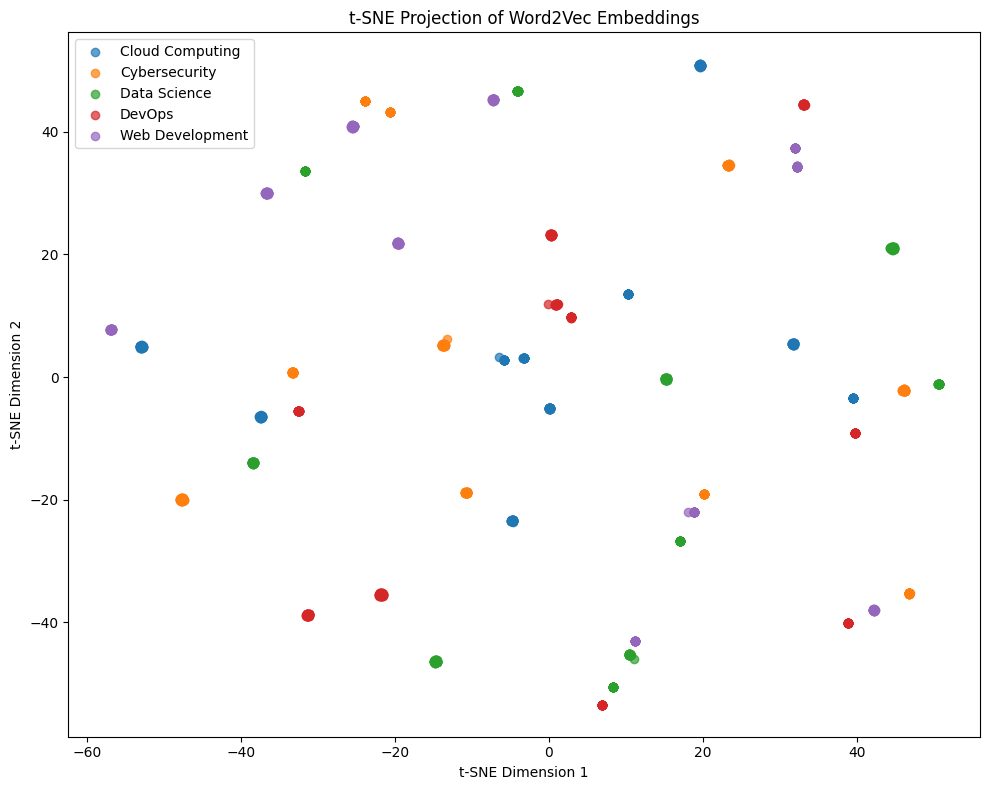

In [ ]:
# Confusion matrix
cmatrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# PCA visualization
pca = PCA(n_components=2, random_state=42)
proj_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
for i, domain in enumerate(le.classes_):
    mask = y == i
    plt.scatter(proj_pca[mask, 0], proj_pca[mask, 1], label=domain, alpha=0.7)
plt.legend()
plt.title('PCA Projection of Word2Vec Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
proj_tsne = tsne.fit_transform(X)
plt.figure(figsize=(10, 8))
for i, domain in enumerate(le.classes_):
    mask = y == i
    plt.scatter(proj_tsne[mask, 0], proj_tsne[mask, 1], label=domain, alpha=0.7)
plt.legend()
plt.title('t-SNE Projection of Word2Vec Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()


## Saving the Model and Artifacts

Save the trained KNN model, label encoder, and Word2Vec model for future use.


In [ ]:
# Create directory if not exists
os.makedirs('models_it', exist_ok=True)

# Save models
joblib.dump(best_knn, 'models_it/knn_model.joblib')
joblib.dump(le, 'models_it/label_encoder.joblib')
w2v_model.save('models_it/word2vec.model')
print('Models saved to models_it directory.')


Models saved to models_it directory.


## Inference: Predicting Domains for New Questions

Demonstrate how to use the model for predicting domains on new questions.


In [ ]:
# Sample questions
sample_questions = [
    'How to tune hyperparameters for a Random Forest classifier?',
    'What steps should I take to secure SSH on a Linux server?',
    'How to configure Nginx as a reverse proxy for a Node.js app?',
    'What is the difference between Docker and Kubernetes?',
    'How to migrate a database to AWS RDS?'
]

# Preprocess
clean_samples = [clean_text(q) for q in sample_questions]
sample_tokens = [s.split() for s in clean_samples]
sample_emb = np.vstack([sentence_vector_w2v(t, w2v_model, embedding_dim) for t in sample_tokens])

# Predict
preds = best_knn.predict(sample_emb)
predicted_domains = le.inverse_transform(preds)

# Display results
for q, d in zip(sample_questions, predicted_domains):
    print(f'Question: {q} \nPredicted Domain: {d}\n')


Question: How to tune hyperparameters for a Random Forest classifier? 
Predicted Domain: Cybersecurity

Question: What steps should I take to secure SSH on a Linux server? 
Predicted Domain: Cybersecurity

Question: How to configure Nginx as a reverse proxy for a Node.js app? 
Predicted Domain: Data Science

Question: What is the difference between Docker and Kubernetes? 
Predicted Domain: Web Development

Question: How to migrate a database to AWS RDS? 
Predicted Domain: Data Science

